# Dragonfruit AI Assessment

Well, to solve this task, I have made use of several tools, ChatGPT being the obvious. Other than this, libraries such as numpy, opencv, scipy (these three for amtrix operations) and matplotlib (for visualization) have also been used for expedited solving. We first start off by generating the images and then perform operations as per the questions given to us.

## Question 1

Come up with ecient data structures to represent both types of images: those generated by the microscope, and those generated by the dye sensor. These need not have the same representation; the only requirement is that they be compact and take as little storage space as possible. Explain why you picked the representation you did for each image type, and if possible estimate how much storage would be taken by the images. What is the worst-case storage size in bytes for each image representation you chose?

#### Answer:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For the image taken by a microscope, it is said that each parasite occupies 25% or more of the total area of the image and each image that is captured by the microscope is of a single microorganism. The pixel value is 0 (black) if it is a part of the blob otherwise it is 1 (white). From this we can infer that any image would contain a continuous large uniform region representing a parasite/sourrounding, in other words, there are likely to be long runs of black/white pixels (and long runs of white pixels), given that the parasite occupies ateast 25% of the image. On the other hand, image taken by a dye sensor represents the area containing dye and gives us information about whether the parasite has cancer or not. Let the spot lit up be represented by 1 (white) and other spots by 0 (black). We know that the lit up spot would consititue to a very small fraction, as a result, the huge image would be filled with a lot of 0's. For both cases, we will be using array data structure. In this data structure, we encode the run-length encoding to store the information of the pixel values, compressing the actual image significantly in a lossless fashion. For the image captured by the dye sensor, we can also use a sparse matrix representation (CSR, for example). Every index in the array would hold a value representing the pixel value and its occurrence, that is, `a[i] = str<xp>`, where `p={0, 1}` and `x is an integer representing the count`. For example, if the pixel value, 1 is occurring 13 times, it is represented as 131.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Here we assume that, we are dealing with 8 bits (1 byte) image. First, let us estimate the size of the actual image. Given that it is a binary image, we can say that it has one channel. Each pixel can take values between `[0, 225]`, unsigned int8. Therefore, the total size of the image would be `100,000 * 100,000 * 1` bits, `10GB`. The same stands for the image taken by the dye sensor. For our representation (both the image taken by microscope and dye sensor), the worst-case happens when colors alternate every pixel in which case, the storage size would be `100000 * 100000 * sizeOf(string of 2 chars)`, in which case, its a bad idea to use this approach. As per the given clause, this is unlikely to happen.

## Question 2

Before the researchers give you real images to work with, you would like to test out any code you write. To this end, you would like to create “fake” simulated images and pretend they were captured by the microscope and the dye sensor. Using the data structures you chose in (1) above, write code to create such simulated images. Try and be as realistic in the generated images as possible.

In [1]:
# import necessary libraries
import sys
import cv2
import copy
import random
import threading
import itertools
import numpy as np
from tqdm import tqdm
from scipy import sparse
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
def generate_microscope_image(rows: int = 128, cols: int = 128, min_coverage: float = 0.25, max_coverage: float = 0.75, k: tuple = (3, 3), resize: tuple = (100000, 100000)) -> tuple:
    '''
        This funciton geenrates an image similar to one generated by the microscope.
        Input params: rows - height of the sample image
                      cols - width of the sample image
                      min_coverage - minimum fraction occupied by the blob in the image
                      max_coverage - maximum fraction occupied by the blob in the image
                      k - kernel size
                      resize - size of the true image to be generated
        Returns: tuple - (sample iamge, scaled sample image)
    '''
    img = np.zeros((rows, cols), dtype=np.uint8)
    kernel = np.ones(k, dtype=np.uint8)
    kernel[k[0]//2, k[1]//2] = 0
    x = random.randint(0, rows-1)
    y = random.randint(0, cols-1)
    img[x, y] = 1
    steps = random.randint(int(min_coverage * rows * cols), int(max_coverage * rows * cols))
    ctr = 0
    while ctr <= steps:
        candidate = signal.convolve2d(img, kernel, mode='same')
        mask = (img == 1) & (candidate < 8)
        mask = np.argwhere(mask)
        x, y = mask[np.random.choice(len(mask))]
        direction = np.random.choice(8)
        if direction == 0: # N
            x = x - 1
        elif direction == 1: # E 
            y = y + 1
        elif direction == 2: # S
            x = x + 1
        elif direction == 3: # W
            y = y - 1
        elif direction == 4: # NE 
            x = x - 1
            y = y + 1
        elif direction == 5: # SE
            x = x + 1
            y = y + 1
        elif direction == 6: # SW
            x = x + 1
            y = y - 1
        elif direction == 7: # NW
            x = x - 1
            y = y - 1
        if 0 <= x < rows and 0 <= y < cols and img[x, y] == 0:
            img[x, y] = 1
            ctr += 1
        if ctr == steps:
            break
    return ((1-img), cv2.resize((1-img), resize))

def generate_dye_sensor_image(microscope_img: np.ndarray, rows:int = 128, cols: int = 128, kernel_th_frac: float = 0.75, cancer_prob: float = 0.5, dye_spread_count: int = 10, dye_spread_frac: float = 0.1, resize: tuple = (100000, 100000)) -> tuple:
    '''
        This funciton geenrates an image similar to one generated by the dye sensor.
        Input params: microscope_img - sample generated image by the microscope 
                      rows - height of the sample image
                      cols - width of the sample image
                      kernel_th_frac - threshold for genrating mask
                      cancer_prob - probability of cancer being present in the blob
                      dye_spread_count - number of iterations to generate dye blobs
                      dye_spread_frac - spread control
                      resize - size of the true image to be generated
        Returns: tuple - (sample iamge, scaled sample image)
    '''
    spread = random.randint(5, int(microscope_img.shape[1] * dye_spread_frac))
    kernel = np.ones((spread, spread), dtype=np.uint8)
    dye_image = np.zeros((microscope_img.shape[0], microscope_img.shape[1]), dtype=np.int8)
    kernel_sum = spread*spread
    for _ in range(random.randint(1, dye_spread_count)):
        candidate = signal.convolve2d(microscope_img, kernel, mode='same')
        if random.random() < cancer_prob:
            mask = (microscope_img == 0) & (candidate == 0)
        else:
            mask = (microscope_img == 1) & (candidate > kernel_sum*kernel_th_frac)
        mask = np.argwhere(mask)
        if len(mask) > 0:
            x, y = mask[np.random.choice(len(mask))]
        else:
            x = random.randint(0, microscope_img.shape[1])
            y = random.randint(0, microscope_img.shape[0])
        dye_image = cv2.circle(dye_image, (x, y), spread, (255, 255, 255), -1)
        dye_image = gaussian_filter(dye_image, sigma=(random.randint(0, 13), random.randint(0, 13)))
    return (dye_image, cv2.resize(np.float32(dye_image), resize).astype(np.uint8))

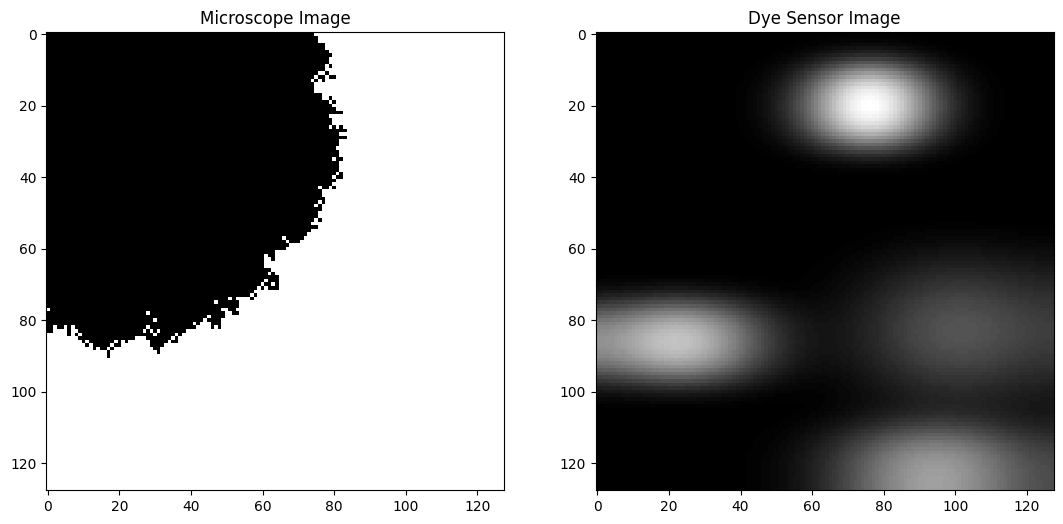

CPU times: user 25.3 s, sys: 23.4 s, total: 48.7 s
Wall time: 28.8 s


In [3]:
%%time
# Visualization of the generated image
true_microscope_img, resized_microscope_img = generate_microscope_image()
true_dye_sensor_img, resized_dye_sensor_img = generate_dye_sensor_image(true_microscope_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 13))
ax1.imshow(true_microscope_img, cmap="gray")
ax1.set_title("Microscope Image")
ax2.imshow(np.int8(true_dye_sensor_img), cmap="gray")
ax2.set_title("Dye Sensor Image")
plt.show()

In [4]:
# Store in our data structure | list using RLE.
def encode_image(img: np.ndarray, divs: int = 5, with_thresholding: bool = False) -> list:
    '''
        This funciton encodes a given image using RLE.
        Input params: img - image to encode
                      divs - number of segments to be done on image
                      with_thresholding - bool value, whether to apply thresholding to the image or not
        Returns: list - encoded item
    '''
    if with_thresholding: 
        img = cv2.threshold(np.float32(img), 23, 255, cv2.THRESH_BINARY_INV)[1]
        img /= 255
        img = img.astype(np.uint8)
    record = []
    splits = np.linspace(0, img.shape[0], divs).astype(int)
    for i in range(1, len(splits)):
        instance = []
        for key, group in itertools.groupby(img[splits[i-1]: splits[i], :].flatten()):
            cipher = f"{len(tuple(group))}{key}"
            instance.append(cipher)
        record.append(instance)
    return record

def decode_image(record: list, width: int = 100000, height: int = 100000, divs: int = 5) -> np.ndarray:
    '''
        This funciton decodes a given list.
        Input params: record - encoded image
                      width - width of the image
                      height - height of the image
                      divs - number of segments to be done on image
        Returns: numpy array - decoded image
    '''
    
    splits = np.linspace(0, height, divs).astype(int)
    img = np.ones((height, width), dtype=np.uint8)

    def process_record(instance, start_idx, end_idx):
        img_list = []
        for px_info in instance:
            px_info_str = px_info
            px = int(px_info_str[-1])
            count = int(px_info_str[:-1])
            img_list += [px] * count
        img[start_idx: end_idx, :] = np.asarray(img_list).reshape((end_idx-start_idx, width))
    
    threads = [threading.Thread(target=process_record, args=(record[i-1], splits[i-1], splits[i])) for i in range(1, len(splits))]
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    return img

In [5]:
%%time
encoded_microscope_img = encode_image(resized_microscope_img)
print(f"Size of image from microscope in GB = {resized_microscope_img.nbytes/1e+9} GB")
print(f"Size of image from microscope in GB, after compressing = {float(sys.getsizeof(encoded_microscope_img)/1e+9)} GB")

Size of image from microscope in GB = 10.0 GB
Size of image from microscope in GB, after compressing = 8.8e-08 GB
CPU times: user 4min 42s, sys: 43.6 s, total: 5min 26s
Wall time: 5min 30s


In [6]:
%%time
recovered_resized_microscope_img = decode_image(encoded_microscope_img)

CPU times: user 6min 25s, sys: 45.5 s, total: 7min 11s
Wall time: 7min 8s


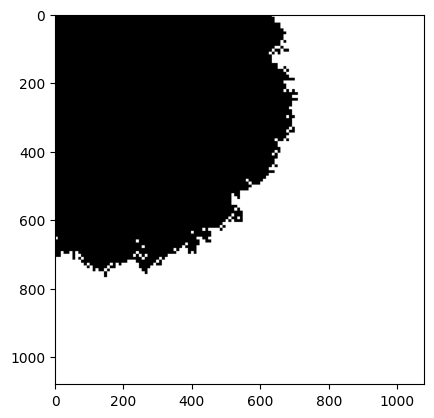

In [7]:
# Visualization of the recovered microscope image
plt.imshow(cv2.resize(recovered_resized_microscope_img, (1080, 1080)), cmap="gray")

In [8]:
# Validating whether the recovered image is the same as the generated image
np.array_equal(resized_microscope_img, recovered_resized_microscope_img)

True

In [9]:
%%time
encoded_dye_sensor_img = encode_image(resized_dye_sensor_img, with_thresholding=True)
print(f"Size of image from microscope in GB = {resized_dye_sensor_img.nbytes/1e+9} GB")
print(f"Size of image from microscope in GB, after compressing = {float(sys.getsizeof(encoded_dye_sensor_img)/1e+9)} GB")

Size of image from microscope in GB = 10.0 GB
Size of image from microscope in GB, after compressing = 8.8e-08 GB
CPU times: user 4min 53s, sys: 1min 43s, total: 6min 37s
Wall time: 6min 11s


In [10]:
%%time
recovered_resized_dye_img = 1 - decode_image(encoded_dye_sensor_img)

CPU times: user 6min 22s, sys: 54.9 s, total: 7min 17s
Wall time: 7min 15s


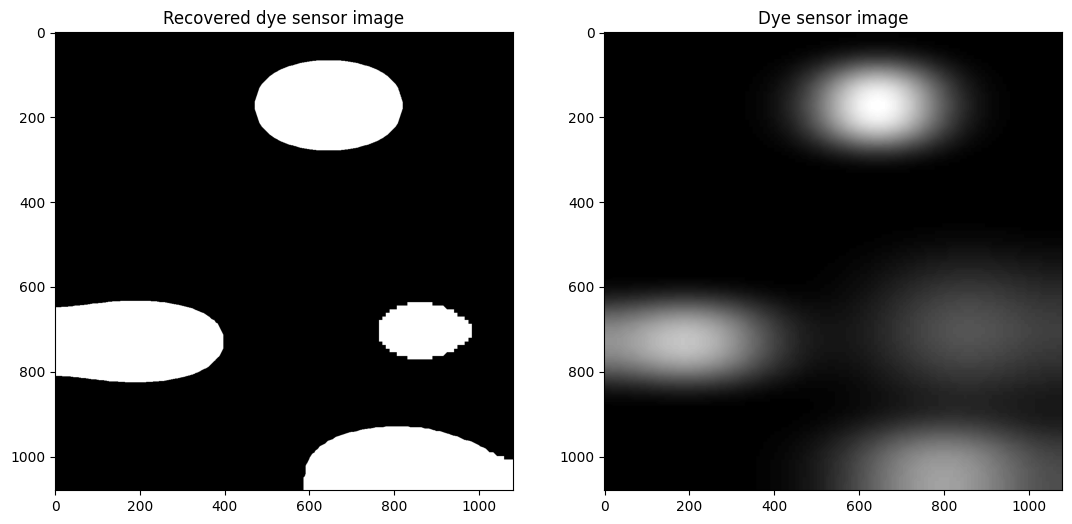

In [11]:
# Visualization of the recovered dye sensor image after thresholding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 13))
ax1.imshow(cv2.resize(recovered_resized_dye_img, (1080, 1080)), cmap="gray")
ax1.set_title("Recovered dye sensor image")
ax2.imshow(cv2.resize(resized_dye_sensor_img, (1080, 1080)), cmap="gray")
ax2.set_title("Dye sensor image")
plt.show()

## Question 3

Using the simulated images generated by the code you wrote for (2) above as input, write a function to compute whether a parasite has cancer or not.

In [20]:
# To allow easier visualization
vis_resize = (1080, 1080)

In [21]:
%%time
cancer_img = cv2.bitwise_and(recovered_resized_dye_img, recovered_resized_dye_img, mask = 1-recovered_resized_microscope_img)

CPU times: user 1.58 s, sys: 1.82 s, total: 3.4 s
Wall time: 3.39 s


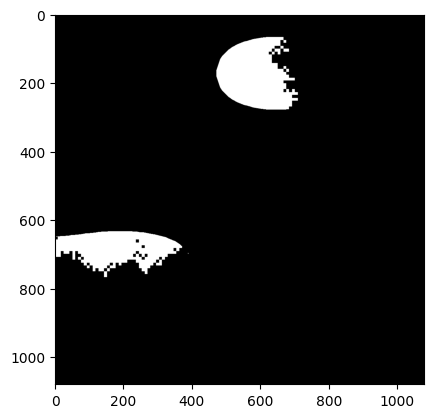

In [22]:
plt.imshow(cv2.resize(cancer_img, vis_resize), cmap="gray")

In [23]:
%%time
# A parasite is deemed to have cancer if the total amount of dye detected in its body exceeds 10% of the area occupied by the parasite in the image.
ones_dye_coverage = np.sum(cancer_img==1)
zeros_blob_coverage = np.sum(recovered_resized_microscope_img==0)
diffusion_percentage = (ones_dye_coverage / zeros_blob_coverage) * 100
print("Number of ones in dye: ", ones_dye_coverage)
print("Number of ones in blob: ", ones_blob_coverage)
if diffusion_percentage >= 10:
    print(f"The parasite has cancer | diffusion percentage = {diffusion_percentage}.")
else:
    print("The parasite does not have cancer.")

Number of ones in dye:  549848906
Number of ones in blob:  1497117
The parasite has cancer | diffusion percentage = 14.685319227341582.
CPU times: user 11.3 s, sys: 1.83 s, total: 13.1 s
Wall time: 12.7 s


## Question 4

You give your code from (3) to the researchers, who run it and find that it is running too slowly for their liking. What can you do to improve the execution speed? Write the code to implement the fastest possible version you can think of for the function in (3)

### Solution 1

A simple immediate solution is to simply resize the image to a reasonable amount. The result will be close to true one. This is demonstrated as follows:

In [24]:
resize_to = (2000, 2000)
resized_to_microscope_img = cv2.resize(recovered_resized_microscope_img, resize_to)
resized_to_dye_sensor_img = cv2.resize(recovered_resized_dye_img, resize_to)

In [25]:
%%time
cancer_img = cv2.bitwise_and(resized_to_dye_sensor_img, resized_to_dye_sensor_img, mask = 1-resized_to_microscope_img)

CPU times: user 1.26 ms, sys: 112 ms, total: 114 ms
Wall time: 113 ms


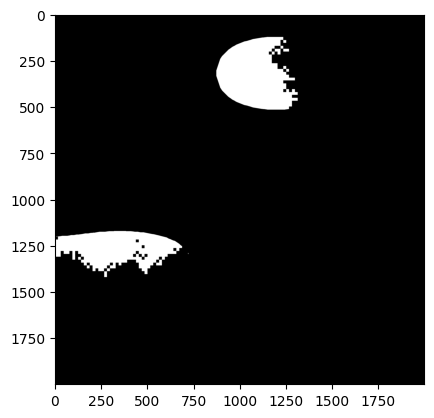

In [26]:
plt.imshow(cv2.resize(cancer_img, resize_to), cmap="gray")

In [27]:
%%time
# A parasite is deemed to have cancer if the total amount of dye detected in its body exceeds 10% of the area occupied by the parasite in the image.
ones_dye_coverage = np.sum(cancer_img==1)
zeros_blob_coverage = np.sum(resized_to_microscope_img==0)
diffusion_percentage = (ones_dye_coverage / zeros_blob_coverage) * 100
print("Number of ones in dye: ", ones_dye_coverage)
print("Number of ones in blob: ", ones_blob_coverage)
if diffusion_percentage >= 10:
    print(f"The parasite has cancer | diffusion percentage = {diffusion_percentage}.")
else:
    print("The parasite does not have cancer.")

Number of ones in dye:  219726
Number of ones in blob:  1497117
The parasite has cancer | diffusion percentage = 14.676608441424419.
CPU times: user 15.2 ms, sys: 771 µs, total: 16 ms
Wall time: 4.67 ms


### Solution 2

We can leveragethe GPU, using opencv through cuda. Numba is yet another tool like numpy that leverages GPU. This assignment was done on Mac, therefore, I was unable to reproduce the result by the method.